# Stable Diffusion Benchmark

In [1]:
# !pip install -Uq diffusers transformers fastcore

In [2]:
!nvidia-smi

Thu Dec  1 10:19:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 32%   50C    P5    14W / 250W |     82MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
import torch
torch.cuda.set_device(0)

/home/seb.derhy/anaconda3/envs/sdv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [4]:
from PIL import Image
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [5]:
from tqdm.auto import tqdm

In [6]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Test pipeline

In [8]:
prompt = "a photo of an astronaut riding a horse"
# prompt = "A model eating ice cream"
# prompt ='A digital illustration of a steampunk library with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors'

guidance_scale = 7.5
num_inference_steps = 50

device = torch.device("cuda")
num_images_per_prompt = 1

In [9]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-base"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 17391.72it/s]


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


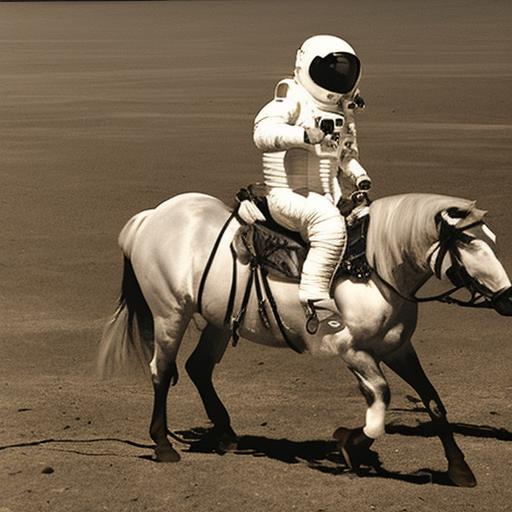

In [10]:
torch.manual_seed(42)
image = pipe(prompt, device=device, 
             guidance_scale=guidance_scale, 
             num_inference_steps=num_inference_steps, 
             num_images_per_prompt=num_images_per_prompt).images[0]  
image

In [11]:
ref_image = image.copy()

# Reproduce inference loop 

In [12]:
def regular_update(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    return latents

In [13]:
def my_sd_sampling(prompt=prompt, device=device, 
             guidance_scale=guidance_scale, 
             num_inference_steps=num_inference_steps, 
             num_images_per_prompt=num_images_per_prompt, 
             custom_update=None):
    
    # 0. Default height and width to unet
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    height, width

    # 1. Check inputs. Raise error if not correct
    pipe.check_inputs(prompt, height, width, callback_steps=1)

    # 2. Define call parameters
    batch_size = 1 if isinstance(prompt, str) else len(prompt)
    batch_size

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt
    text_embeddings = pipe._encode_prompt(prompt, device, num_images_per_prompt, 
                                          do_classifier_free_guidance, negative_prompt=None)

    # 4. Prepare timesteps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps

    # 5. Prepare latent variables
    num_channels_latents = pipe.unet.in_channels
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        text_embeddings.dtype,
        device,
        generator=None,
        latents=None,
    )

    with torch.no_grad():
        # 7. Denoising loop
        for i, t in enumerate(pipe.progress_bar(timesteps)):
            if custom_update is not None:
                latents = custom_update(latents, i, t, text_embeddings, do_classifier_free_guidance)
            else:
                latents = regular_update(latents, i, t, text_embeddings, do_classifier_free_guidance)

        # 8. Post-processing
        image = pipe.decode_latents(latents)

        # 10. Convert to PIL
        images = pipe.numpy_to_pil(image)
    
    return images

In [14]:
torch.manual_seed(42)
imgs = my_sd_sampling()

100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


In [15]:
import numpy as np
diff = np.array(imgs[0])-np.array(ref_image)
np.linalg.norm(diff)

0.0

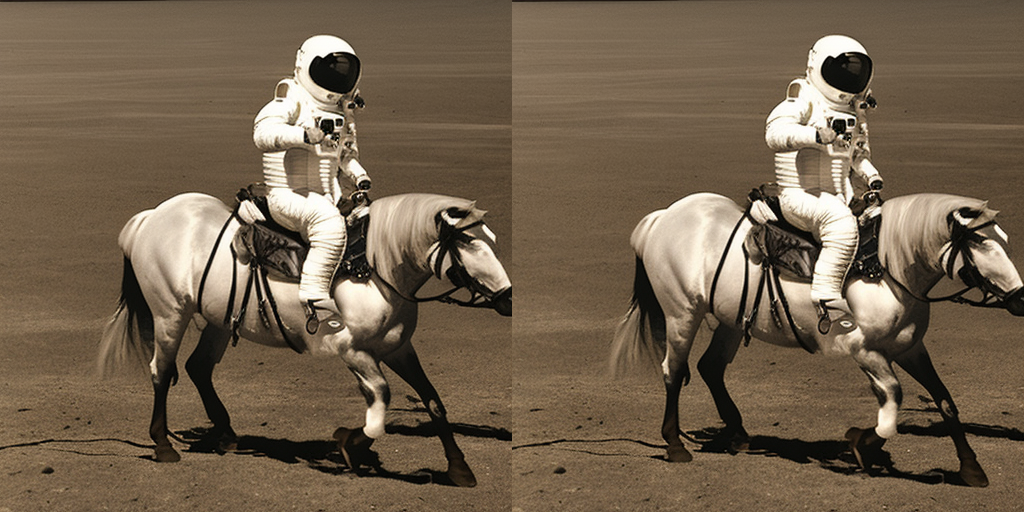

In [16]:
image_grid([ref_image, imgs[0]], rows=1, cols=2)

# Pipeline improvement with rescale

In [17]:
def update_with_rescale(latents, i, t, text_embeddings, do_classifier_free_guidance):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        noise_pred = noise_pred/noise_pred.norm()*noise_pred_uncond.norm() ### THIS IS THE IMPORTANT LINE

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    return latents

In [18]:
torch.manual_seed(42)
imgs = my_sd_sampling(custom_update=update_with_rescale)

100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


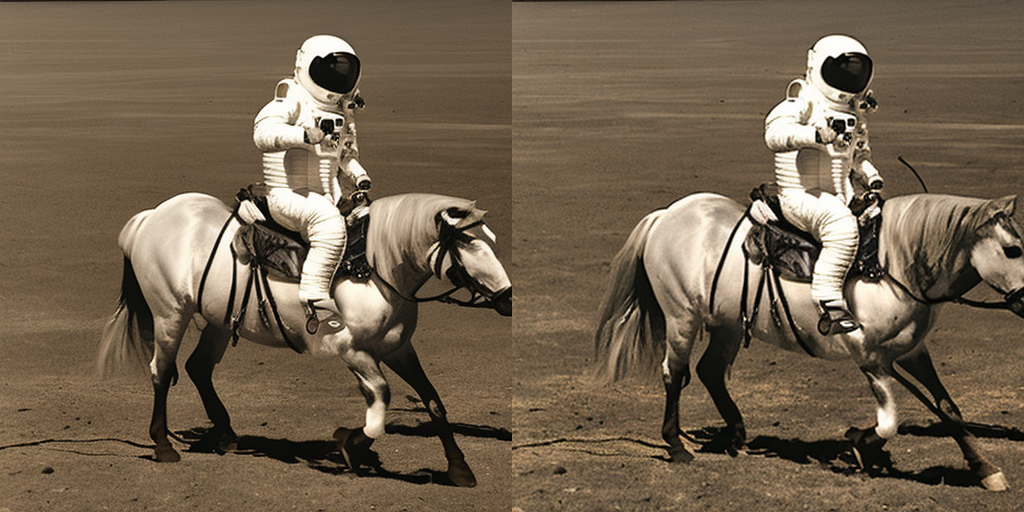

In [19]:
image_grid([ref_image, imgs[0]], rows=1, cols=2)

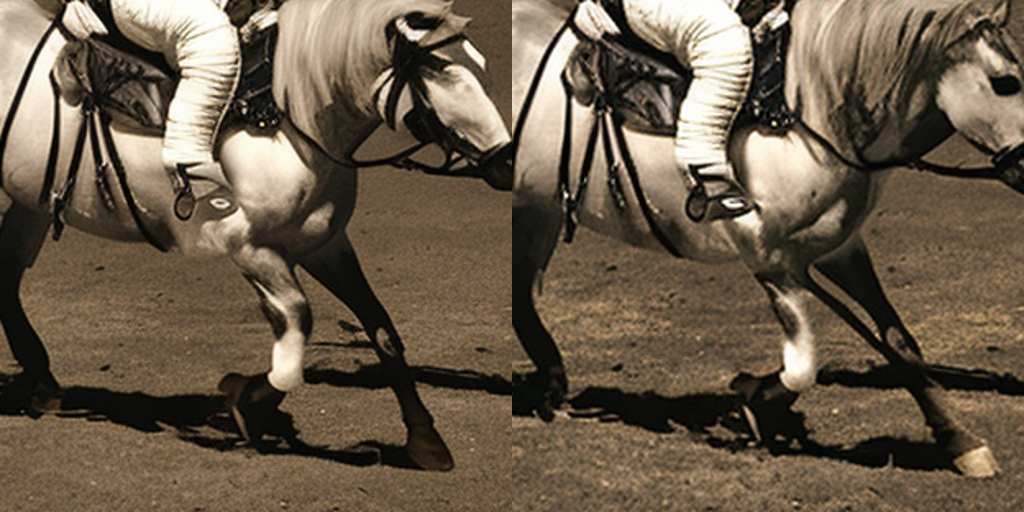

In [22]:
crop_box = (200, 200, 512, 512)
sz = (512, 512)
image_grid([ref_image.crop(crop_box).resize(sz), imgs[0].crop(crop_box).resize(sz)], rows=1, cols=2)